# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.092232,False,-1.467122
1,-0.553488,True,5.092333
2,-2.721292,False,0.557821
3,-0.860433,False,-0.864048
4,-1.078330,True,3.316149
...,...,...,...
995,-1.934879,False,-0.464891
996,-0.240524,False,-0.196877
997,-1.365115,False,1.737968
998,-1.312072,False,-0.211613


<Axes: xlabel='v0'>

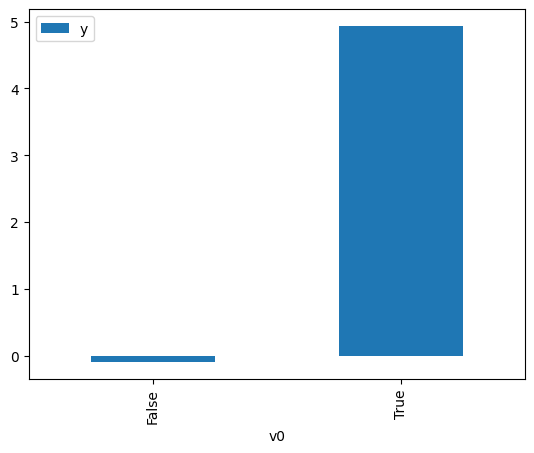

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

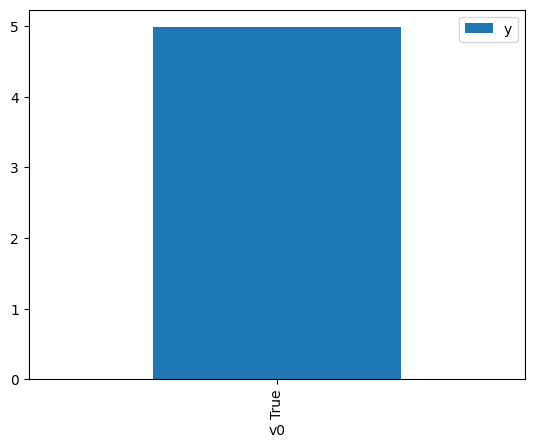

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.762795,False,-1.106836,0.741823,1.348030
1,-0.639424,False,-1.569639,0.713176,1.402178
2,0.270371,False,0.446674,0.461197,2.168270
3,-1.889006,False,0.264200,0.914941,1.092967
4,-0.732039,False,0.578589,0.734859,1.360806
...,...,...,...,...,...
995,-2.200991,False,1.705738,0.939414,1.064493
996,0.338915,False,-0.224639,0.441305,2.266005
997,-0.556969,False,-0.198539,0.693007,1.442988
998,-1.732231,False,0.170568,0.899507,1.111720


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.687302,True,3.268349,0.275483,3.629985
1,-1.452541,True,5.436494,0.134246,7.449006
2,-0.978979,True,4.749862,0.212678,4.701941
3,-0.397370,True,5.544810,0.348158,2.872257
4,0.406560,True,5.071772,0.578143,1.729677
...,...,...,...,...,...
995,-0.943522,True,5.675177,0.219720,4.551243
996,-1.128276,True,6.212309,0.184846,5.409895
997,0.130132,True,6.075339,0.497787,2.008891
998,0.092802,True,4.321617,0.486851,2.054015


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.906
Model:                            OLS   Adj. R-squared (uncentered):              0.906
Method:                 Least Squares   F-statistic:                              4820.
Date:                Mon, 21 Apr 2025   Prob (F-statistic):                        0.00
Time:                        07:38:51   Log-Likelihood:                         -1406.3
No. Observations:                1000   AIC:                                      2817.
Df Residuals:                     998   BIC:                                      2826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0705      0.029      2.444      0.015       0.014       0.127
x2             4.9838      0.051     97.384      0.000       4.883       5.084
==============================================================================
Omnibus:                        2.579   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.275   Jarque-Bera (JB):                2.490
Skew:                           0.075   Prob(JB):                        0.288
Kurtosis:                       2.808   Cond. No.                         1.79
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""